<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_4/fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сверточная сеть в Keras

На лекции мы узнали, что свертки можно комбинировать, применяя друг за другом. Это увеличивает их рецептивное поле и позволяет выучить более сложные признаки. 

В этом уроке мы с вами обучим нашу первую свертоную нейронную сеть для задачи классификации одежды. Вот как будет выглядеть наш датасет

<img src="https://1.bp.blogspot.com/-AIPR5UuydTY/WbCLlGEmoAI/AAAAAAAAA2U/Teu6q2FF9LslUL6t6Qn5YjzGWNfHC7y7wCLcBGAs/s1600/fashion-mnist-sprite.png" width="600">

Он называется FashionMnist. Название не случайно похоже на Mnist -- с рукописными цифрами -- FashionMnist придумали как замену Mnist, потому что он стал уж слишком простым для современных нейронных сетей. Как вы помните, на нем мы без труда достигли 97-98% точности. 

** перед тем как начать выполнять код мы изменим Runtime на Runtime c GPU. В этом модуле это просто необходимо для ускорения работы*

In [2]:
import tensorflow as tf
print(tf.__version__)
#tf.enable_eager_execution()
import matplotlib.pyplot as plt

2.8.2


In [3]:
mapping = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
           4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag",
           9: "Ankle boot"}  # датасет содержит 10 классов

def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {mapping[labels[i]]}. Pred: {mapping[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {mapping[labels[i]]}")

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


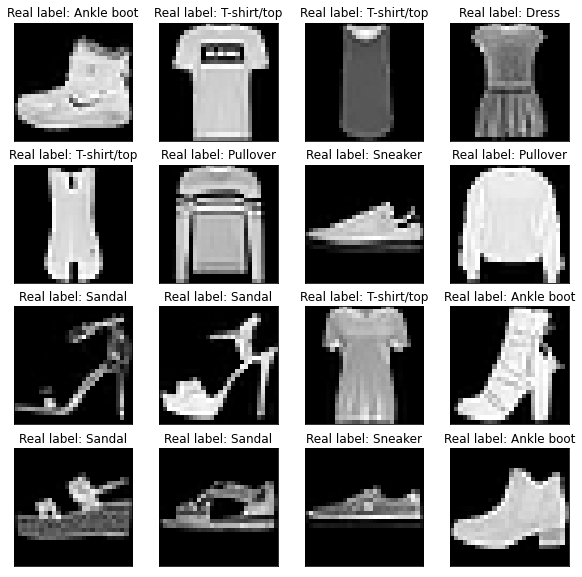

In [4]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

show_mnist(x_train, y_train)
print(x_train.shape, x_test.shape)

Для начала попробуем обучить на новом датасете полносвязную сеть. В точности такую же как мы обучали ранее.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=15, 
          validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
469/469 [==============================] - 4s 3ms/step - loss: 0.5094 - accuracy: 0.8202 - val_loss: 0.4385 - val_accuracy: 0.8435
Epoch 2/15
469/469 [==============================] - 1s 3ms/step - loss: 0.3715 - accuracy: 0.8662 - val_loss: 0.3892 - val_accuracy: 0.8566
Epoch 3/15
469/469 [==========

Мы смогли достичь точности только около 88%. Сможем ли мы лучше с помощью сверточной нейронной сети? Давайте попробуем.

In [6]:
# помним, что для работы со сверточной сетью нам нужны 4х мерные тензоры -- меняем размеры
x_train = x_train[..., None]
x_test = x_test[..., None]
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


Мы построим архитектуру по следующим правилам:
*   Будем использовать сверточные слои 3 на 3 с активацией ReLU
*   За сверткой будет следовать слой MaxPool
*   Количество фильтров при уменьшении тензора в два раза (т.е. после MaxPool)будем увеличивать в два раза



In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(28, 28, 1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# т.к. мы используем padding='same', значит, после двух пулингов размер уменьшится ровно в два раза. 
# можем это увидеть на summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


Мы получили тензор размера (7,7,64). Как же мы можем превратить его в классы? Очень просто! Мы уже умеем это делать для полносвязных сетей. Давайте и здесь применем полносвязные слои, чтобы предсказать 10 классов. 

Только перед тем как мы применем полносвязный слой -- мы должны "вытянуть" то, что мы ему подаем в строчку, ведь он ожидает вектор а не многомерный тензор.

Воспользуемся **tf.keras.layers.Flatten()**.

In [8]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

Обратите внимание на количество параметров -- почти в два раза меньше, чем для полносвязной сети.

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=20, 
          validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 12s 6ms/step - loss: 0.5150 - accuracy: 0.8178 - val_loss: 0.3723 - val_accuracy: 0.8684
Epoch 2/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3269 - accuracy: 0.8844 - val_loss: 0.3279 - val_accuracy: 0.8814
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2822 - accuracy: 0.8985 - val_loss: 0.2912 - val_accuracy: 0.8978
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2502 - accuracy: 0.9100 - val_loss: 0.2764 - val_accuracy: 0.9006
Epoch 5/20
469/469 [==============================] - 3s 5ms/step - loss: 0.2282 - accuracy: 0.9177 - val_loss: 0.2635 - val_accuracy: 0.9044
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2099 - accuracy: 0.9239 - val_loss: 0.2582 - val_accuracy: 0.9078
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1915 - accuracy: 0.9309 - val_loss: 0.3065 - val_accuracy: 0.8955
Epoch

Мы получили точность около 91%, что уже лучше, чем точность полносвязной сети для этой же задачи. При этом том, в нашей сети почти в два раза меньше параметров. Мы можем еще увеличить точность немного изменив архитектуру:

In [11]:
# обратите внимание, сейчас перед пуллингом используется два светочных слоя
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(28, 28, 1))) 
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [12]:
model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=20, 
          validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 6s 11ms/step - loss: 0.4769 - accuracy: 0.8286 - val_loss: 0.3278 - val_accuracy: 0.8773
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 0.2795 - accuracy: 0.8997 - val_loss: 0.2675 - val_accuracy: 0.9038
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.2299 - accuracy: 0.9162 - val_loss: 0.2484 - val_accuracy: 0.9122
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.1997 - accuracy: 0.9267 - val_loss: 0.2321 - val_accuracy: 0.9178
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 0.1731 - accuracy: 0.9362 - val_loss: 0.2222 - val_accuracy: 0.9198
Epoch 6/20
469/469 [==============================] - 5s 10ms/step - loss: 0.1539 - accuracy: 0.9437 - val_loss: 0.2289 - val_accuracy: 0.9208
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.1333 - accuracy: 0.9511 - val_loss: 0.2260 - val_accuracy: 0.9229

Как выбрать архитектуру? Как мы обсуждали ранее -- однозначного ответа на этот вопрос нет. Всегда нужно эксперементировать и только так узнавать что лучше подойдет для конкретной задаче. Но через пару уроков мы узнаем про архитектуры, которые уже придумали и продумали за нас и их можно использовать почти без изменений.

# Заключение

В этом уроке мы обучили свою первую сверточную нейронную сеть. Мы увидели, что благодаря Keras делать это очень просто.

Также мы убедились в том, что такая архитектура больше подходит для изображений. И позволяет достичь бОльшей точности при меньшем количестве параметров. 

В следующем практическом задании вы научите сеть классифицировать реальные фотографии кошек и собак. Но перед этим мы немного подготовимся к работе с реальными изображениями в следующем уроке.
